In [61]:
import random
import math
import time
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (24,12)
import seaborn as sns

In [6]:
SCRIPTING_KEY = "jtpsb0vor47z3mv"
SERIES_CODE_LOAD = 'B0610'
SERIES_CODE_WIND_SOLAR_FORECAST = 'B1440'
SERIES_CODE_WIND_SOLAR_ACTUAL = 'B1630'

from bs4 import BeautifulSoup
import httplib2

def read_elexon(date_from, date_to, series_code):
    # Time delta of 1 day. We'll use this to iterate over the dates
    delta = datetime.timedelta(days=1)

    # Pandas dataframe
    df = pd.DataFrame()

    # Iterate over range of dates and get the data
    while (date_from <= date_to):
        # Build the URL
        url = f'https://api.bmreports.com/BMRS/{series_code}/v1?APIKey={SCRIPTING_KEY}&SettlementDate={date_from}&Period=*&ServiceType=xml'
        http_obj = httplib2.Http()

        # Get the data
        resp, content = http_obj.request(uri=url,
                                        method='GET',
                                        headers={'Content-Type': 'application/xml; charset=UTF-8'}, )

        # Dummy data for dry run
        # with open('testdata.xml', 'r') as f:
        #    content = f.read()

        # Make XML into a BeautifulSoup object
        content = BeautifulSoup(content, 'xml')

        # Parse the desired quantity out of the XML
        quantities = [int(float(d.text)) for d in content.find_all('quantity')]
        settlement_period = [int(d.text) for d in content.find_all('settlementPeriod')]

        # Sort the data according to settlement period just to make sure that we have the data in the right order.
        items_sorted = [(y, x) for y, x in sorted(zip(settlement_period, quantities), key=lambda pair: pair[0])]
        settlement_period_sorted, quantities_sorted = list(zip(*items_sorted))

        # Add data to pandas dataframe
        d = {"settlement_date": [date_from] * len(quantities), "settlement_period" : settlement_period_sorted, "quantity": quantities_sorted}
        df = pd.concat([df, pd.DataFrame(data=d)], ignore_index=True)

        # Increase by 1 day
        date_from += delta

        # Sleep for 1 second to avoid overloading the API
        time.sleep(1)

    # Save the pandas dataframe
    df.to_xml(f'data/series_{series_code}.xml', index=False)


In [ ]:
if not os.path.isdir('data'):
    os.makedirs('data')
# There is a 1 sec pause to avoid api overload, so this takes 5-10 mins
read_elexon(datetime.date(2022, 3, 1), datetime.date(2022, 9, 30), SERIES_CODE_LOAD)

In [2]:
# Read data
df = pd.read_xml("data/series_B0610.xml")

# Change date str to datetime object (this can be done when reading from API)
df["settlement_date"] = pd.to_datetime(df["settlement_date"])

In [ ]:
# Basic info
print(df.head(n=10))
print(df.info())
print(df.describe())

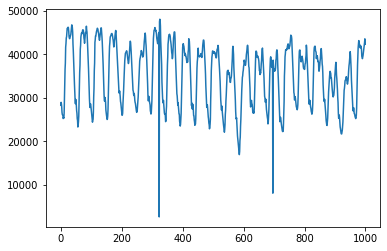

In [4]:
# Plot part of the data
quantity_arr = np.array(df['quantity'])
plt.plot(quantity_arr[0:1000])

In [6]:
# Addfuller stationarity test (need to check for individual training sequences)
from statsmodels.tsa.stattools import adfuller
res = adfuller(df['quantity'])
print(res) # p value is second field

(-4.630262423233173, 0.00011355812055320025, 39, 10265, {'1%': -3.4309872076005172, '5%': -2.8618216086555823, '10%': -2.5669198951435286}, 179683.6520131985)


In [10]:
# How many days with an atypical amount of settlement periods?
sd_counts = df.groupby('settlement_date')['settlement_period'].count()
sd_counts_irreg = sd_counts[sd_counts != 48]

# Days with an atypical amount of settlement periods
print("Amount of atypical days: ", len(sd_counts_irreg))

# Show data from days where amount of settlement periods is atypical
for day, cnt in sd_counts_irreg.items():
    if cnt < 48:
        #print(df[df['settlement_date'] == day])
        print("Settlement period count: ", cnt)
        
        # Plot to see if there is an anomaly here
        #plt.plot(df[df['settlement_date'] == day]['quantity'])

# Minor issue 1): Settlement values from 19 of the days are more or less than the standard 48 settlement periods.
# The values of a specific settlement can be missing or can be duplicate, both in any position.
# Solution: fill in missing values and average duplicate so they do not affect seasonality.
# Minor issue 2): There are noisy dips in the data, we can filter those out by replacing the value with average of neighboring values.


Amount of atypical days:  19
Settlement period count:  47
Settlement period count:  44
Settlement period count:  46
Settlement period count:  44
Settlement period count:  47
Settlement period count:  46
Settlement period count:  47


In [11]:
# Group all duplicate settlement days and periods to their mean
df = df.groupby(["settlement_date", "settlement_period"], as_index=False).mean()

# Get new counts
sd_counts = df.groupby('settlement_date')['settlement_period'].count()
sd_counts_irreg = sd_counts[sd_counts != 48]

# Make new empty dataframe that we will fill with the missing values
df_mv = pd.DataFrame(columns=df.columns)

# Go over each sd from 1 to 48 and fill missing entries with nan quantities
for day, cnt in sd_counts_irreg.items():
    df_day = df[df['settlement_date'] == day]

    # Find out missing periods
    sp_missing = np.setdiff1d(np.arange(1,49), df_day["settlement_period"].values)

    # Make new dataframe
    data = {"settlement_date" : [day] * len(sp_missing), "settlement_period" : sp_missing, "quantity" : None}
    df_missing = pd.DataFrame(data=data)

    df_mv = pd.concat([df_mv, df_missing])

# Add the dataframe with missing values
df = pd.concat([df, df_mv], ignore_index=True)
df = df.sort_values(by=["settlement_date", "settlement_period"], ignore_index=True)

# Get low range outlier values (TODO: Change to more sophisticated method. Use quantile(0.001) BUT PER WEEK, not global!!)
#outlier_thresh = df["quantity"].quantile(0.001)
outlier_thresh = 8200

# Change some very low value outliers to nan
df.loc[df["quantity"] < outlier_thresh, "quantity"] = None

# Intepolate added nan values
df["quantity"] = df["quantity"].interpolate(limit_direction="both")

# Show the days where there are huge dips in the data. On what hours do the dips occur? Are those days linked with some special events?
# After analysis: It looks like it's just noise

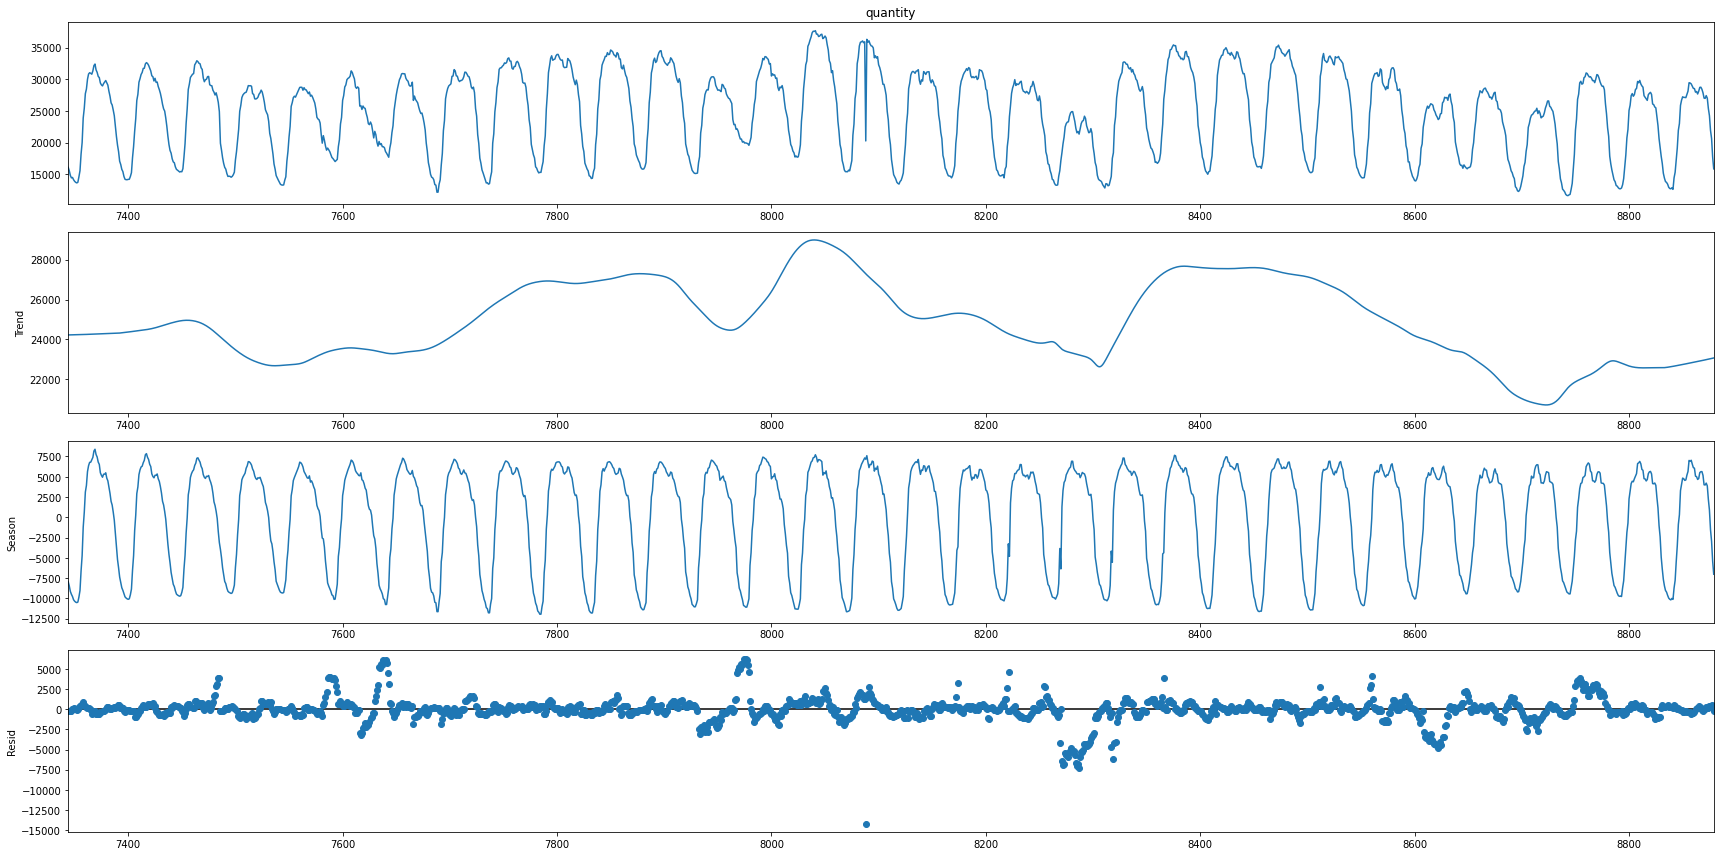

In [62]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.api import SARIMAX, AutoReg
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import mse, rmse, rmspe, meanabs, medianbias

# Decompose month of data to see trend and seasonailty
stl = STL(df.loc[(df["settlement_date"] >= datetime.datetime(2022, 8, 1)) & (df["settlement_date"] <= datetime.datetime(2022, 9, 1))]["quantity"], period=48, robust=True)
res = stl.fit()
fig = res.plot()


# Noise burst patterns seem interesting, likely correlated with external events.

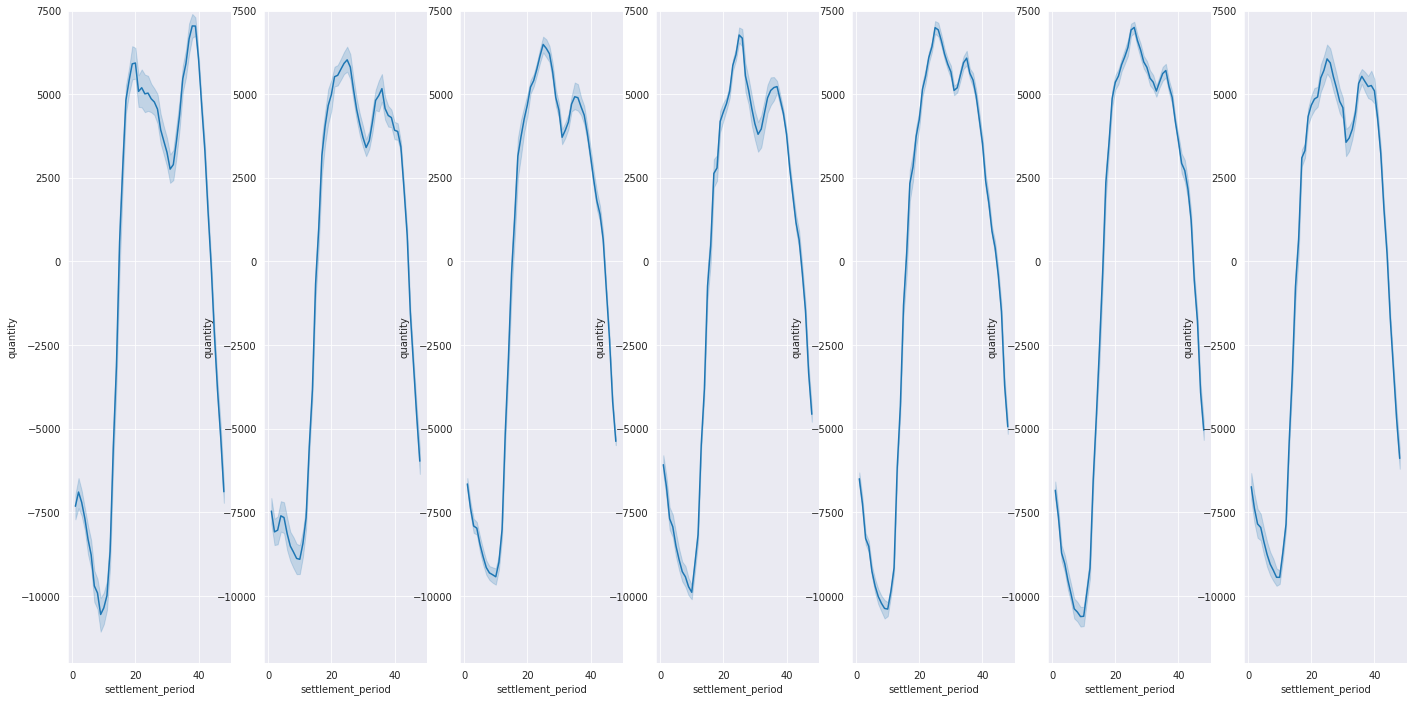

In [43]:
# Plot the "mean" daily cycle for all months
f = plt.figure(figsize=(24, 12))
gs = f.add_gridspec(1,7)

for i in range(3,10):
    start_date = datetime.datetime(2022, i, 1)
    end_date = datetime.datetime(2022, i+1, 1)
    stl = STL(df.loc[(df["settlement_date"] >= start_date) &
                     (df["settlement_date"] <= end_date)]["quantity"], period=48, robust=True)
    res = stl.fit()
    day_seqs = np.array(res.seasonal.values).reshape(-1, 48)
    day_seqs_list = [list(ds) for ds in day_seqs]

    day_seqs_df = pd.DataFrame(data={"settlement_period" : list(range(1, 49)) * int(len(res.seasonal.values) / 48), "quantity" : np.array(res.seasonal.values)})

    with sns.axes_style("darkgrid"):
        ax = f.add_subplot(gs[0, i-3])
        sns.lineplot(data=day_seqs_df, x="settlement_period", y="quantity")

    plt.ylim(-12000, 7500)


In [15]:
def get_default_param_dict():
    param_dict = {}
    param_dict["lossfun"] = rmse
    param_dict["n_lag_days"] = 7
    param_dict["seasonal"] = 7
    param_dict["trend_deg"] = 1
    param_dict["arima_order"] = (1, 0, 0)
    return param_dict

In [16]:
def evaluate_forecasting_model(df, param_dict, model):
    '''
    Return the evaluation of the forecasting model on the whole test set
    :param param_dict:
    :return:
    '''

    n_lag_sp = param_dict["n_lag_days"] * 48 # Amount of settlement periods that model is being conditioned on
    n_eval_sp = 24 # Amount of settlement periods to evaluate the model on (12 hours)
    settlement_period_skip = 8 # Amount of settlement periods to skip between each evaluation (to reduce computational cost)

    # Iterate over each day in september (test month)
    cum_error = 0  # Cumulative error of the model over the entire test set
    eval_ctr = 0
    for i in range(1, 30):
        # Get index of the first settlement period of the day for this date
        base_idx = df.loc[df["settlement_date"] == datetime.datetime(2022, 9, i)].index[0]

        for j in range(1, 48, settlement_period_skip):
            trn_df = df.loc[base_idx - n_lag_sp + j:base_idx + j]
            val_df = df.loc[base_idx + j:base_idx + j + 23]

            model.fit(trn_df["quantity"])

            # Evaluate forecast
            cum_error += param_dict["lossfun"](val_df["quantity"], model.forecast(n_eval_sp))
            eval_ctr += 1

    return cum_error / eval_ctr

In [41]:
def evaluate_forecasting_model_full(df, param_dict, model):
    # Get quantitative evaluation
    score = evaluate_forecasting_model(df, param_dict, model)
    print(f"Model evaluation score on test set: {score}, according to loss function: {param_dict['lossfun']}")

    # Get qualitative evaluation
    base_idx = df.loc[df["settlement_date"] == datetime.datetime(2022, 9, 1)].index[0]
    n_evals = 3

    f = plt.figure(figsize=(24, 12))
    gs = f.add_gridspec(1, n_evals)
    for i in range(n_evals):
        rnd_idx_shift = np.random.randint(1, 15) * 48
        trn_df = df.loc[base_idx - param_dict["n_lag_days"] * 48 + rnd_idx_shift:base_idx + rnd_idx_shift]
        val_df = df.loc[base_idx + rnd_idx_shift:base_idx + rnd_idx_shift + 23]

        model.fit(trn_df["quantity"])
        forecast = model.forecast(24)
        with sns.axes_style("darkgrid"):
            ax = f.add_subplot(gs[0, i])
            plt.plot(trn_df["quantity"], 'b')
            plt.plot(val_df["quantity"], 'g')
            plt.plot(forecast, 'r--')

    plt.show()

In [19]:
def date_and_sp_to_ds(df):
    ds_list = []
    for index, row in df.iterrows():
        ds_list.append(row['settlement_date'].replace(hour=int(math.floor((row['settlement_period'] -1)/ 2)), minute=int(30 * (row['settlement_period'] % 2 == 0))))
    df["ds"] = ds_list
    df["y"] = df["quantity"]
    return df


In [27]:
# Train and eval set
n_lag_sp = 48 * get_default_param_dict()["n_lag_days"]
base_idx = df.loc[df["settlement_date"] == datetime.datetime(2022, 9, 1)].index[0]

#val_df = df.loc[base_idx:]
#print(val_df)

      settlement_date settlement_period  quantity
8832       2022-09-01                 1   15182.0
8833       2022-09-01                 2   14426.0
8834       2022-09-01                 3   13873.0
8835       2022-09-01                 4   13734.0
8836       2022-09-01                 5   13459.0
...               ...               ...       ...
10267      2022-09-30                44   29289.0
10268      2022-09-30                45   28023.0
10269      2022-09-30                46   26501.0
10270      2022-09-30                47   24384.0
10271      2022-09-30                48   22548.0

[1440 rows x 3 columns]


In [28]:
class SameAsYesterdayForecaster:
    def __init__(self):
        pass

    def fit(self, trn_data):
        self.trn_data = trn_data

    def forecast(self, n_steps):
        # Return n_steps of the trn data minus 48 settlement periods
        last_idx = self.trn_data.keys()[-1]
        # Pick the correct segment which corresponds to yesterday's segment
        forecasted_data = self.trn_data.loc[last_idx-48:last_idx-48+n_steps-1]

        # Change the indeces to reflect the future data (for plotting)
        forecasted_data_shifted = pd.Series(data=forecasted_data.values, index=forecasted_data.index + 48)

        return forecasted_data_shifted


Model evaluation score on test set: 2272.522010169751, according to loss function: <function rmse at 0x7f15d57a29d0>


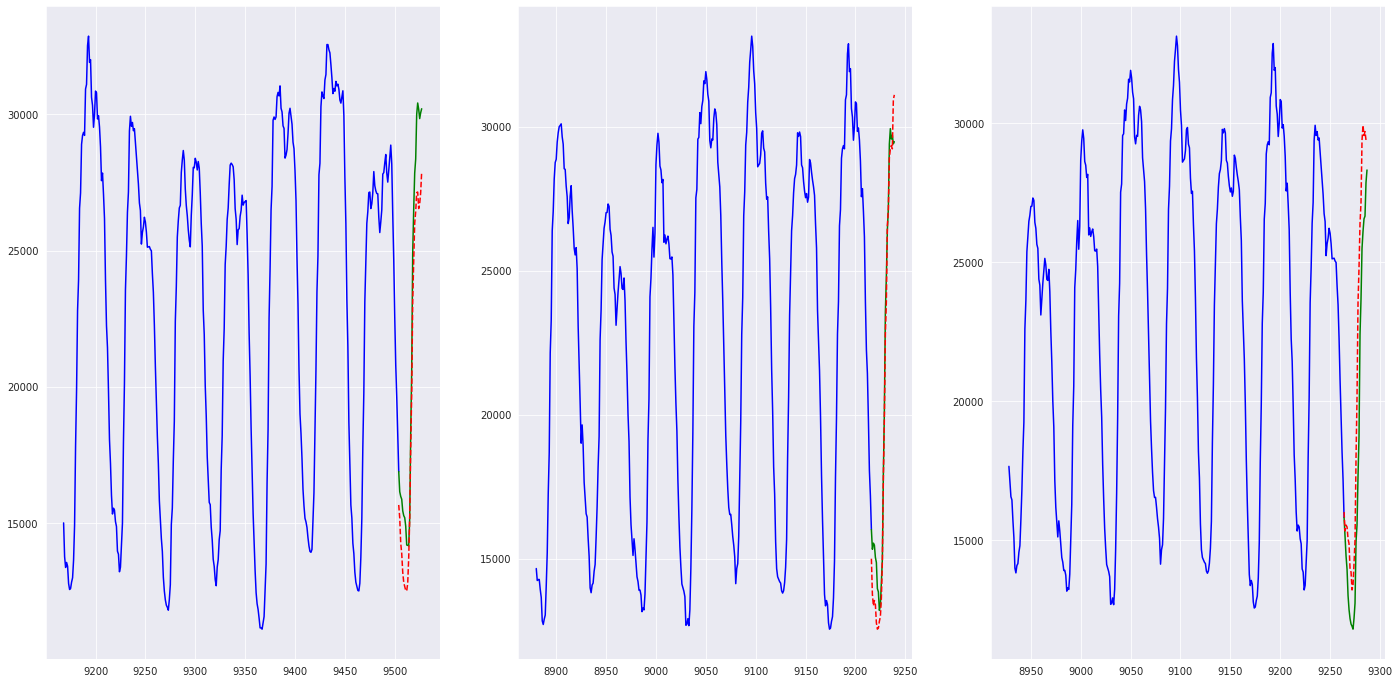

In [42]:
# Baseline forecaster: Same as 24 hours ago
say_model = SameAsYesterdayForecaster()
evaluate_forecasting_model_full(df, get_default_param_dict(), say_model)

In [44]:
class STLClassifierWrapper:
    def __init__(self, param_dict):
        self.stl_model = None
        self.stlf_res = None
        self.param_dict = param_dict

    def fit(self, trn_data):
        # Addfuller stationarity test
        #res = adfuller(trn_data)
        #print(res)

        self.stl_model = STLForecast(trn_data,
                                     ARIMA,
                                     model_kwargs=dict(order=self.param_dict["arima_order"], trend="t"),
                                     period=48,  # 48
                                     seasonal=self.param_dict["seasonal"],  # 3,7
                                     trend_deg=self.param_dict["trend_deg"])  # 1
        self.stlf_res = self.stl_model.fit()

    def forecast(self, steps):
        if self.stlf_res is None:
            raise Exception("Model not fitted yet")
        return self.stlf_res.forecast(steps)


Model evaluation score on test set: 2261.390056667668, according to loss function: <function rmse at 0x7f15d57a29d0>


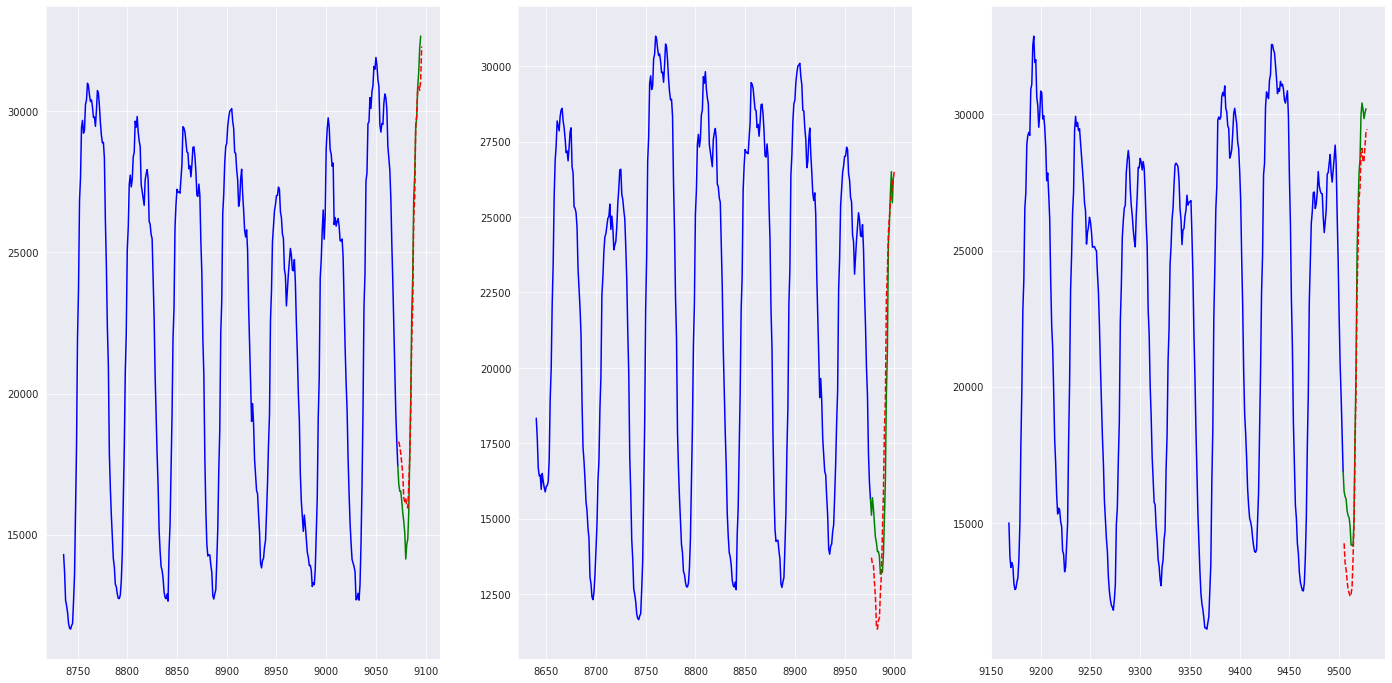

In [45]:
# STL forecasting: (needs hyperparameter tuning. Demo is with only a week of training data for illustration purposes)
stl_model = STLClassifierWrapper(get_default_param_dict())
evaluate_forecasting_model_full(df, get_default_param_dict(), stl_model)

In [ ]:
class SARIMAXWrapper:
    def __init__(self, param_dict):
        self.stl_model = None
        self.stlf_res = None
        self.param_dict = param_dict

    def fit(self, trn_data):
        self.stl_model = SARIMAX(trn_data, order=(1, 0, 0), trend="c")
        self.stlf_res = self.stl_model.fit()

    def forecast(self, steps):
        if self.stlf_res is None:
            raise Exception("Model not fitted yet")
        return self.stlf_res.forecast(steps)


In [ ]:
# SARIMAX (Doesn't converge)
sarimax_model = SARIMAXWrapper(get_default_param_dict())
evaluate_forecasting_model_full(val_df, get_default_param_dict(), sarimax_model)

In [47]:
import torch as T
import torch.nn as nn
import torch.functional as F

class LSTMForecaster(nn.Module):
    def __init__(self, obs_dim, act_dim, hid_dim):
        super(LSTMForecaster, self).__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.hid_dim = hid_dim
        num_layers = 1

        self.rnn = T.nn.LSTMCell(input_size=self.obs_dim, hidden_size=self.hid_dim)
        self.fc1 = T.nn.Linear(self.hid_dim, self.act_dim, bias=True)

    def forward(self, x):
        # Go over the initial sequence to warmup the rnn
        hx, cx = self.forward_warmup(x)
        output = self.forward_forecast(hx, cx, 24)

        return output

    def forward_forecast(self, hx, cx, seq_len):
        # This is the autoregression sequence
        output = []
        y = self.fc1(hx)
        for i in range(seq_len):
            hx, cx = self.rnn(y.detach(), (hx, cx))
            y = self.fc1(hx)
            output.append(y)
        output = T.stack(output, dim=0)[:, :, 0].T
        return output

    def forward_warmup(self, x):
        # Make seq dim first
        x = x.T

        # If output dim is 1 then add artificial dimension
        if len(x.shape) == 2:
            x = x.unsqueeze(2)

        seq_len, batch_size = x.size()[0:2]
        hx = T.randn(batch_size, self.hid_dim)  # (batch, hidden_size)
        cx = T.randn(batch_size, self.hid_dim)

        # This is the warmup sequence
        for i in range(seq_len - 24):
            hx, cx = self.rnn(x[i], (hx, cx))

        return hx, cx

    def train(self, df, n_lag_days=3, n_iters=1000, batch_size=32, lr=0.001):
        # Make training set out of dataframe
        start_date = datetime.datetime(2022, 3, 1)
        end_date = datetime.datetime(2022, 9, 1)
        val_start_date = datetime.datetime(2022, 9, 1)
        val_end_date = datetime.datetime(2022, 9, 26)
        trn_df = df.loc[(df["settlement_date"] >= start_date) &
                        (df["settlement_date"] <= end_date)]
        val_df = df.loc[(df["settlement_date"] >= val_start_date) &
                        (df["settlement_date"] <= val_end_date)]

        seq_len = 2 * 48 + 24 # 2 days conditioning + 12 hours forcasting

        # delta time
        delta = datetime.timedelta(days=1)

        # Dataset
        seq_list = []

        # iterate over range of dates and make training set
        while (start_date <= end_date):
            base_idx = df.loc[df["settlement_date"] == start_date].index[0]
            for j in range(1, 48):
                seq_df = df.loc[base_idx + j:base_idx + j + seq_len - 1]["quantity"]
                seq_arr = np.array(seq_df.values)
                seq_list.append((seq_arr - seq_arr.mean()) / seq_arr.std())
            start_date += delta

        # Validation dataset
        seq_list_val = []

        # iterate over range of dates and make test set
        while (val_start_date <= val_end_date):
            base_idx = df.loc[df["settlement_date"] == val_start_date].index[0]
            for j in range(1, 48):
                seq_df = df.loc[base_idx + j:base_idx + j + seq_len - 1]["quantity"]
                seq_arr = np.array(seq_df.values)
                seq_list_val.append((seq_arr - seq_arr.mean()) / seq_arr.std())
            val_start_date += delta

        # Make trainingset into pytorch tensor
        seq_T = T.tensor(seq_list, dtype=T.float32)
        seq_T_val = T.tensor(seq_list_val, dtype=T.float32)

        # Define training tools
        lossfun = T.nn.MSELoss()
        optim = T.optim.Adam(self.parameters(), lr=lr)

        n_data = seq_T.shape[0]

        for i in range(n_iters):
            # Select random seq
            rnd_ideces = np.random.choice(np.arange(n_data), batch_size)
            rnd_seqs = seq_T[rnd_ideces]

            # Forward pass conditioned on input
            y = self.forward(rnd_seqs)

            # Loss on predicted outputs
            loss = lossfun(y, rnd_seqs[:, -24:])

            # Backward pass
            loss.backward()

            # If enough iters, step gradient
            if i % batch_size == 0 and i > 0:
                optim.step()
                optim.zero_grad()

            # Evaluate
            if i % 100 == 0:
                cum_loss = 0
                y = self.forward(seq_T_val)
                cum_loss += lossfun(y, seq_T_val[:, -24:]).data
                print(f"For iter: {i}/{n_iters}, trn_loss: {loss.data}, val_loss: {cum_loss}")

    def fit(self, trn_data):
        trn_data_arr = np.array(trn_data.values)
        self.mean, self.std = trn_data_arr.mean(), trn_data_arr.std()
        trn_data_norm = (trn_data_arr - self.mean) / self.std
        trn_data_norm_T = T.tensor(trn_data_norm, dtype=T.float32).unsqueeze(0)

        self.hx, self.cx = self.forward_warmup(trn_data_norm_T)
        self.last_index = trn_data.index[-1]

    def forecast(self, seq_len):
        y = self.forward_forecast(self.hx, self.cx, seq_len).detach().numpy()[0]
        y_denorm = y * self.std + self.mean
        current_index = self.last_index + 1
        y_ser = pd.Series(y_denorm, index=range(current_index, current_index + seq_len))
        return y_ser


For iter: 0/10000, trn_loss: 0.8708693981170654, val_loss: 0.9203119874000549
For iter: 100/10000, trn_loss: 0.8232796788215637, val_loss: 0.9151508212089539
For iter: 200/10000, trn_loss: 0.8470316529273987, val_loss: 0.9105280041694641
For iter: 300/10000, trn_loss: 0.8399126529693604, val_loss: 0.9062622785568237
For iter: 400/10000, trn_loss: 0.9390814900398254, val_loss: 0.9024514555931091
For iter: 500/10000, trn_loss: 0.8795597553253174, val_loss: 0.8988373279571533
For iter: 600/10000, trn_loss: 0.962810754776001, val_loss: 0.895200788974762
For iter: 700/10000, trn_loss: 0.8356124758720398, val_loss: 0.8913207650184631
For iter: 800/10000, trn_loss: 1.0126255750656128, val_loss: 0.885188102722168
For iter: 900/10000, trn_loss: 0.9299367070198059, val_loss: 0.8796115517616272
For iter: 1000/10000, trn_loss: 0.9705093502998352, val_loss: 0.8731310367584229
For iter: 1100/10000, trn_loss: 0.9073400497436523, val_loss: 0.865993082523346
For iter: 1200/10000, trn_loss: 0.9055050015

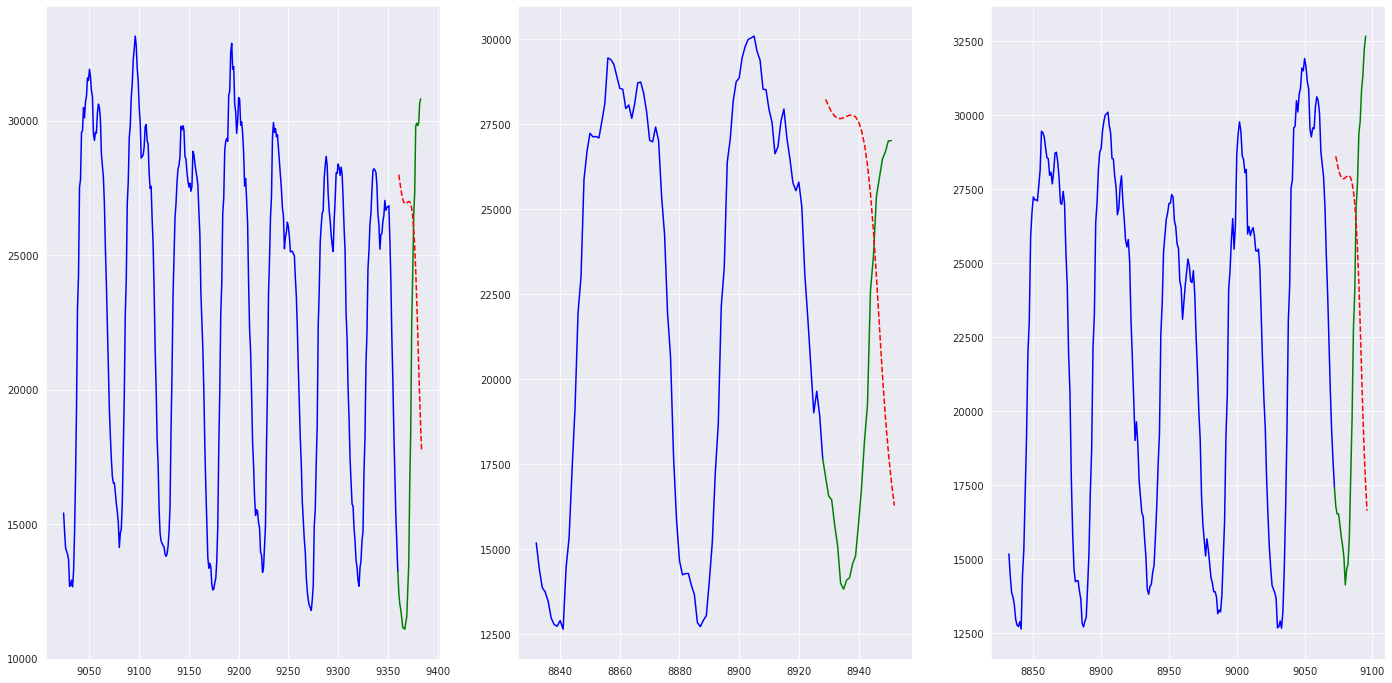

In [51]:
# LSTM model (Bug in output probably, wrong part of output is predicted. Training seems fine though, but need to verify). Training parameters need to be tuned as well.
lstm_model = LSTMForecaster(obs_dim=1, act_dim=1, hid_dim=32)
lstm_model.train(df, n_lag_days=3, n_iters=10000, batch_size=32, lr=0.001)
evaluate_forecasting_model_full(val_df, get_default_param_dict(), lstm_model)

/home/silverjoda/SW/ml_ops/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_27860/2952295250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ds"] = ds_list
/tmp/ipykernel_27860/2952295250.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"] = df["quantity"]
/tmp/ipykernel_27860/2952295250.py:

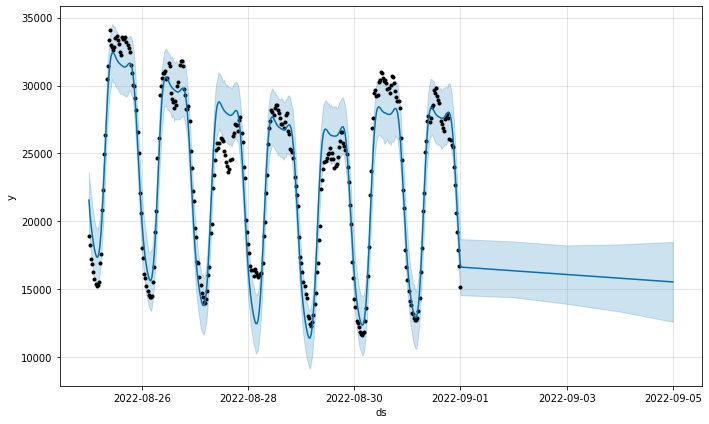

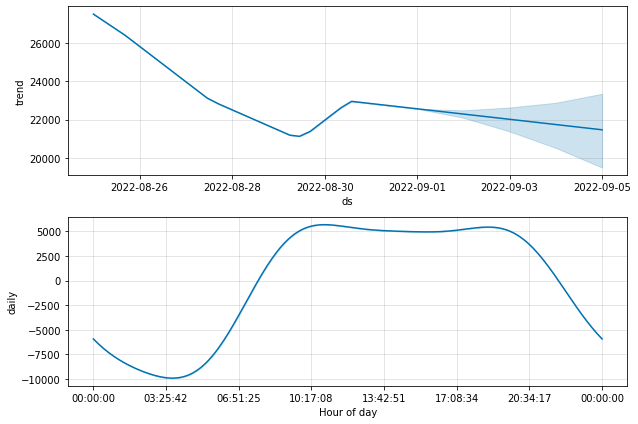

In [22]:
# Prophet Forecasting tool by META (needs hyperparam tuning)
from prophet import Prophet

trn_df = df.loc[base_idx - n_lag_sp:base_idx]
val_df = df.loc[base_idx:base_idx + 23]

# Make the dataframe with ds and y columns, as required for the prophet interface
trn_df = date_and_sp_to_ds(trn_df)
val_df = date_and_sp_to_ds(val_df)

m = Prophet()
m.fit(trn_df)
    
future = m.make_future_dataframe(periods=4)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [55]:
import optuna
def optimize_forecasting_model(df, stl_model):
    '''
    Return dict of optimal parameters and optimal cost function
    :return:
    '''

    def objective(df, stl_model, trial):
        param_dict = {}
        param_dict["lossfun"] = rmse
        param_dict["n_lag_days"] = trial.suggest_int("n_lag_days", 1, 14)
        param_dict["seasonal"] = trial.suggest_categorical("seasonal", [3, 7, 9])
        param_dict["trend_deg"] = trial.suggest_categorical("trend_deg", [1, 2, 3])
        #ao_0 = trial.suggest_int("arima_order", 1, 3)
        #ao_1 = trial.suggest_int("arima_order", 1, 3)
        #ao_2 = trial.suggest_int("arima_order", 1, 3)
        #param_dict["arima_order"] = (ao_0, ao_1, ao_2)
        param_dict["arima_order"] = (1, 0, 0)

        score = evaluate_forecasting_model(df, param_dict, stl_model)

        return score

    timeout = 60.0
    print(f"Running optimization for {timeout} seconds...")
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda t: objective(df, stl_model, t), timeout=timeout)

    print(f"Best value is : {study.best_value}, with param vec: {study.best_params}")


In [56]:
# Use Optuna to optimize STL hyperparameters
optimize_forecasting_model(df, stl_model)

[I 2022-10-06 11:28:06,249] A new study created in memory with name: no-name-f831e03c-dee3-448a-ba3e-5ec895a6c064


Running optimization for 60.0 seconds...


[I 2022-10-06 11:28:14,814] Trial 0 finished with value: 2264.329398002973 and parameters: {'n_lag_days': 8, 'seasonal': 3, 'trend_deg': 2}. Best is trial 0 with value: 2264.329398002973.
[I 2022-10-06 11:28:20,693] Trial 1 finished with value: 2330.54656706272 and parameters: {'n_lag_days': 4, 'seasonal': 7, 'trend_deg': 3}. Best is trial 0 with value: 2264.329398002973.
[I 2022-10-06 11:28:27,832] Trial 2 finished with value: 2257.341990646102 and parameters: {'n_lag_days': 6, 'seasonal': 9, 'trend_deg': 3}. Best is trial 2 with value: 2257.341990646102.
[I 2022-10-06 11:28:39,427] Trial 3 finished with value: 2243.1235314448368 and parameters: {'n_lag_days': 14, 'seasonal': 3, 'trend_deg': 1}. Best is trial 3 with value: 2243.1235314448368.
[I 2022-10-06 11:28:49,552] Trial 4 finished with value: 2252.289539443551 and parameters: {'n_lag_days': 11, 'seasonal': 9, 'trend_deg': 2}. Best is trial 3 with value: 2243.1235314448368.
[I 2022-10-06 11:28:56,700] Trial 5 finished with value:

Best value is : 2243.1235314448368, with param vec: {'n_lag_days': 14, 'seasonal': 3, 'trend_deg': 1}
